# Train, Test, and Redeploy a Hugging Face Model

This notebook demonstrates how to train a Hugging Face model using transfer learning and build an automated ML pipeline for data preparation, training, evaluation, testing, model optimization, and deployment of an application pipeline with the new model.

The [**previous notebook**](./01-serving.ipynb) used a standard Hugging Face model. In this notebook, you will use the US Airline Sentiment dataset to generate a more accurate model, and once the model is ready, you will deploy it to staging or production.

Tutorial steps:
- [**Run full workflow with train, optimze & deploy**](#full-workflow)
- [**Try the new model with Gradio**](#use-gradio)

<a id="define-project"></a>
## Define MLRun project and set all mlrun function

Create or load an MLRun project that holds all your functions and configuration ([**project_setup.py**](./src/project_setup.py))

The project contains the following functions:
* Data preparation (in [**data_prep.py**](./src/data_prep.py))
* Training and Optimization (in [**trainer.py**](./src/trainer.py))
* stress testing (in [**serving_test.py**](./src/serving_test.py))

And a training pipeline (in [**training_workflow.py**](./src/training_workflow.py))

In [1]:
from src.project_setup import create_and_set_project

project = create_and_set_project(name="huggingface", user_project=True)

> 2023-02-19 12:21:01,956 [info] loaded project huggingface from MLRun DB


<a id="full-workflow"></a>
## Run full workflow with train, optimze & deploy

Run the training pipeline (in [**training_workflow.py**](./src/training_workflow.py)) by using `project.run(workflow name, ..)`.


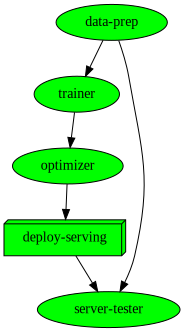

uid,start,state,name,parameters,results
...a63ce663,Feb 19 12:34:01,completed,server-tester,label_column=labelsendpoint=http://huggingface-yaronh-serving-staging-huggingface-yaronh.default-tenant.app.cto-office.iguazio-cd1.com/,count=100error_count=0avg_latency=79303min_latency=16580max_latency=108512
...f0a52f43,Feb 19 12:30:37,completed,optimizer,model_path=store://artifacts/huggingface-yaronh/trained_model:834c1873-18c4-46c7-9144-69b798461fa2,
...5d18848a,Feb 19 12:21:44,completed,trainer,pretrained_tokenizer=distilbert-base-uncasedpretrained_model=distilbert-base-uncasednum_epochs=1,loss=0.0448learning_rate=0.0eval_loss=0.16107356548309326eval_accuracy=0.9366666666666666eval_f1=0.8256880733944955eval_runtime=12.4585eval_samples_per_second=24.08eval_steps_per_second=1.525train_runtime=485.1833train_samples_per_second=6.183train_steps_per_second=0.387total_flos=34259380977408.0
...ac9dcebc,Feb 19 12:21:15,completed,data-prep,dataset_name=Shayanvsf/US_Airline_Sentiment,


In [2]:
workflow_run = project.run(
    name="training_workflow",
    arguments={
        "dataset_name": "Shayanvsf/US_Airline_Sentiment",
        "pretrained_tokenizer": "distilbert-base-uncased",
        "pretrained_model": "distilbert-base-uncased",
        "num_epochs": 1
    },
    watch=True,
    dirty=True
)

Here we can see how the workflow looks on our UI & Also the result of the trainer and the server_tester

<img src="./images/workflow.png" alt="workflow" width="1200"/>

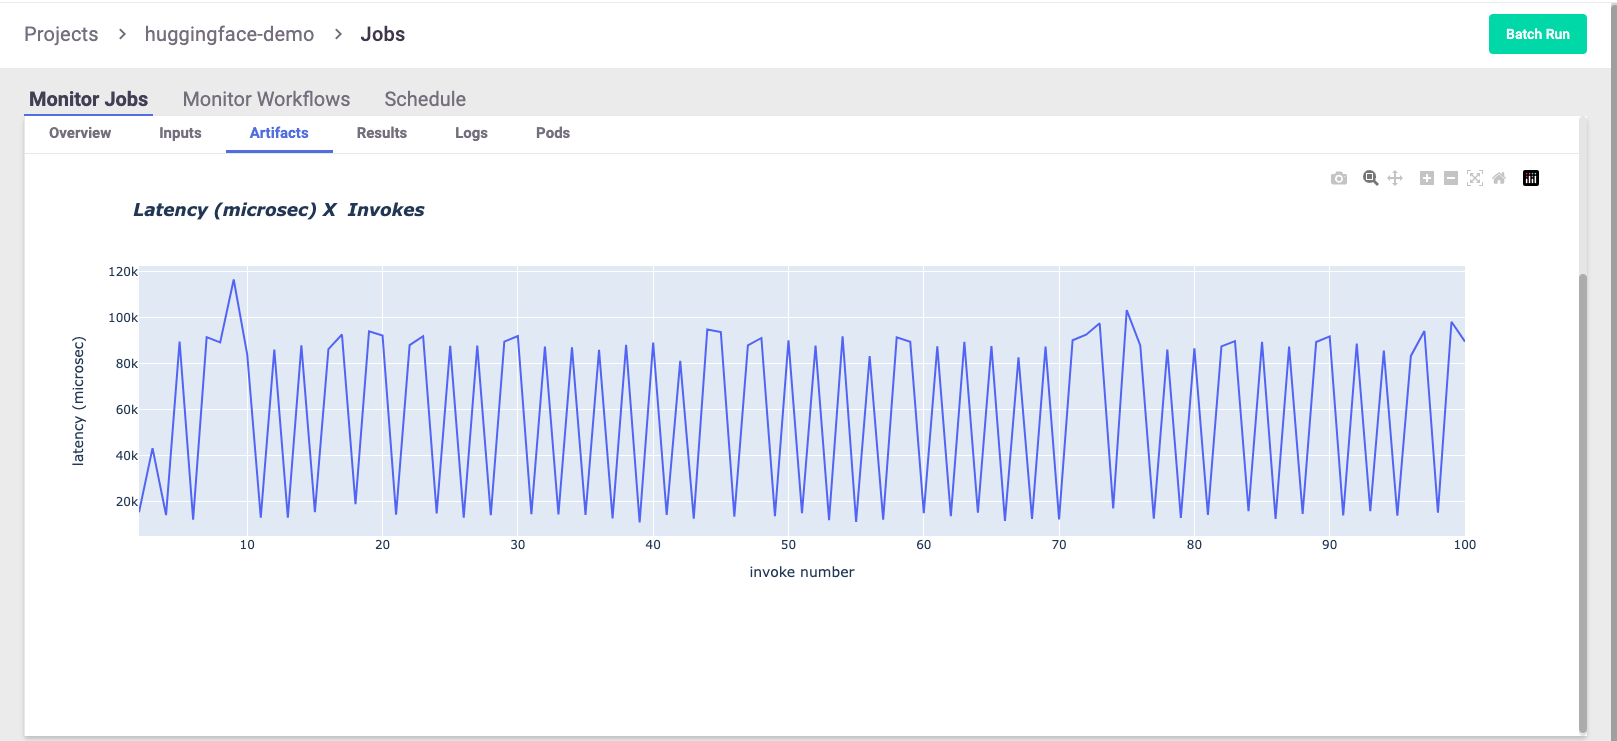<img src="./images/latancy.png" alt="latancy" width="1200"/>

<a id="use-gradio"></a>
## Try the new model with Gradio

Once the pipeline completes, you can try the model using the function `invoke()` method or Gradio. You can get the new function object using the project `get_function()` method. 

In [3]:
serving_function = project.get_function("serving:staging")

In [4]:
body = "i love flying"
response = serving_function.invoke(path='/predict', body=body)
print(response)

> 2023-02-19 12:39:39,857 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-huggingface-yaronh-serving-staging.default-tenant.svc.cluster.local:8080/predict'}
['The sentiment is POSITIVE', 'The prediction score is 0.5876932144165039']


In [5]:
import gradio as gr
import requests

serving_function._get_state()
serving_url = serving_function._resolve_invocation_url("", False)

def sentiment(text):
    # call the serving function with the input text
    resp = requests.post(serving_url, json={"text": text})
    return resp.json()

with gr.Blocks() as demo:
    input_box = [gr.Textbox(label="Text to analyze", placeholder="Please insert text", value="It was Terrible fight")]
    output = [gr.Textbox(label="Sentiment result"), gr.Textbox(label="Sentiment score")]
    greet_btn = gr.Button("Submit")
    greet_btn.click(fn=sentiment, inputs=input_box, outputs=output)

In [6]:
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://8dc22e83-451e-4cea.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


**Done !**